<a href="https://colab.research.google.com/github/ShyamSundhar1411/My-ML-Notebooks/blob/master/Transfer%20Learning/Transfer_Learning_Fine_Tuning_Flower_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data

In [1]:
import tensorflow as tf
import tensorflow_datasets as tdfs
import pandas as pd
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-24 20:40:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-24 20:40:48 (78.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import plot_loss_curves,walk_through_dir

In [4]:
import tensorflow_datasets as tfds
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

228813984/228813984 [==============================] - 6s 0us/step


In [6]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(data_dir,image_size = (224,224),batch_size = 32,subset = "training",validation_split = 0.2,seed = 42)
test_data = image_dataset_from_directory(data_dir,image_size = (224,224),batch_size = 32,subset = "validation",validation_split = 0.2,seed = 42)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Visualizing Data

In [17]:
def load_and_prep_image(filename,img_shape=224):
  """Reads an image from filename and preprocess it to tensor and reshapes it to (img_shape,img_shape,color channels)"""
  img = tf.io.read_file(filename)
  img = tf.image.decode_image(img)
  img = tf.image.resize(img,[img_shape,img_shape])
  img = img/255.
  return img

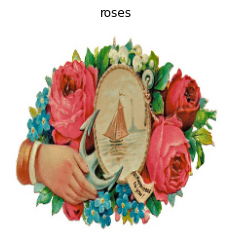

In [28]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def plot_random_image(class_names,data_dir):
  class_name = random.choice(class_names)
  directory = str(data_dir)+'/'+class_name
  img = str(random.sample(os.listdir(directory),1)[-1])
  img = load_and_prep_image(directory+'/'+img)
  plt.imshow(img)
  plt.axis(False)
  plt.title(class_name)
class_names = train_data.class_names
plot_random_image(class_names,data_dir)

## Data Augmentation Layers and Checkpoint layers

In [35]:
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
])
checkpoint_path_efficient_net = "efficient_net_checkpoint/checkpoint_base.ckpt"
efficient_net_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath =checkpoint_path_efficient_net,
    save_best_only = True,
    save_weights_only = True,
    save_freq = "epoch"
    )

## Backbone Model EfficientNetB6

In [34]:
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB6(include_top = False)
base_model.trainable = False

#Input Layers
inputs = tf.keras.layers.Input(shape = input_shape,name = "input_layer")



165234480/165234480 [==============================] - 5s 0us/step


In [36]:
base_model.summary()

Model: "efficientnetb6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   